### Code for generation of Figure 8
_Integrative analysis of cell state changes in lung fibrosis with peripheral protein biomarkers'_
in EMBO Molecular Medicine. <br> 
Christoph H. Mayr, Lukas M. Simon, Gabriela Leuschner, et al. and Fabian J. Theis, Herbert Schiller

In [1]:
## This Notebook is based on the anndata object generated in integrate_munich_chicago_nashville_cohorts.ipynb
## raw counts for additional Chicago and Nashville Patients were obtained from 2 recent publications 
## Chicago (Reyfman PA et al, 2018) and Nashville (Habermann AC et al, 2019)

import scanpy as sc
import bbknn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")

import matplotlib.colors as colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

plt.rcParams['figure.figsize'] = (6, 5)
folder = "~/20200210_Schiller_humanILD_meshal.ansari/"

sc.logging.print_version_and_date()

Running Scanpy 1.6.1.dev110+gb4234d81, on 2021-02-11 14:05.


### Define Functions used in this Notebook

In [2]:
def get_scaled_meanExp(genes, adata, xlabel = "dpt_pseudotime"):
    use_raw = False if adata.raw is None else True
    genExp = sc.get.obs_df(adata, keys = genes + [xlabel], layer = None, use_raw = use_raw)

    ## Bin the DPT values and calculate mean expression per bin
    genExp["dpt_bins"] = np.digitize(genExp.dpt_pseudotime, np.arange(0, 1, 0.1))
    mean_dpt = pd.DataFrame(columns = genes)
    mean_dpt["dpt_bins"] = [i for i in range(1, 11)]

    for gene in genes:
        mean_dpt[gene] = genExp.groupby(["dpt_bins"])[gene].mean().reset_index()[gene]
        mean_dpt[gene] = np.interp(mean_dpt[gene], (mean_dpt[gene].min(), mean_dpt[gene].max()), (0, +1))
    return mean_dpt

def lineplot_scaled_meanExp(mean_dpt, cols, xlabel = "dpt_bins", figsize = (10, 6)):
    patches = []
    fig, ax = plt.subplots(figsize = figsize)
    
    for i, gene in enumerate(mean_dpt.columns.values[:-1]):
        cat = sb.regplot(data = mean_dpt, x = xlabel, y = gene, scatter = False, order = 3, truncate = True,
                         ax = ax, color = cols[i], ci = 0)
        patches.append(mpatches.Patch(color = cols[i], label = gene))
    
    cat.set_ylabel("expression", size = 15)
    cat.set_xlabel("pseudotime", size = 15)
    sb.despine()
    plt.legend(handles = patches, loc = "center left", bbox_to_anchor=(1.02, 0.5),
               prop = {"size": 10}, frameon = False)
    plt.show()

### Read in Data Object

... storing 'data_set' as categorical


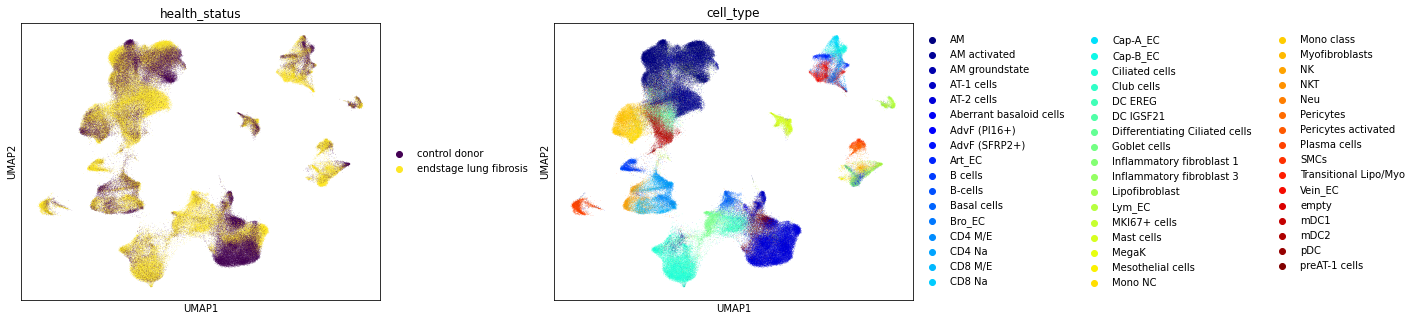

In [3]:
adata = sc.read(folder + "integrated_human_dataset.h5ad")
adata.obs["data_set"] = ["Munich" if p.startswith("muc") else "Chicago" if p.startswith("GS")
                         else "Nashville" for p in adata.obs.patient_id]
sc._utils.sanitize_anndata(adata)
adata.obs.data_set.cat.reorder_categories(["Nashville", "Chicago", "Munich"], inplace = True)

sc.pl.umap(adata, color = ["health_status", "cell_type"], wspace = 0.35)

#### Figure 8 b) UMAP colored by gene expression for CRTAC1

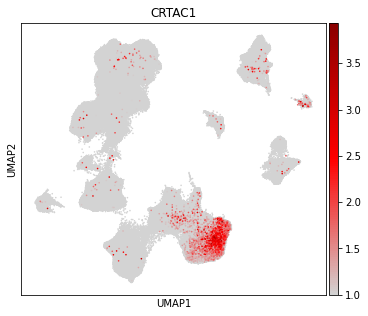

In [4]:
sc.pl.umap(adata, color = ["CRTAC1"], cmap = gray_red, size = 10, vmin = 1)

### AT-2 cell Trajectory in only ILD Patients

In [9]:
## Original Parameters for diffmap Calculation
# alv = adata[(adata.obs["cell_type"].isin(["AT-2 cells", "Aberrant basaloid cells", "preAT-1 cells"])) &
#             (adata.obs["health_status"] == "endstage lung fibrosis")].copy()
# sc.pp.highly_variable_genes(alv, min_disp = None, max_disp = None, min_mean = None, max_mean = None, 
#                             batch_key = "data_set", n_top_genes = 4000, n_bins = 20, flavor = "cell_ranger")
# vartab = pd.DataFrame(alv.var["highly_variable_nbatches"], index = adata.var_names)
# hvgs = vartab[vartab.highly_variable_nbatches.values >= 2].index
# alv.var["highly_variable"] = [g in hvgs for g in sub.var_names]

# sc.pp.pca(alv, use_highly_variable = True)
# bbknn.bbknn(alv, neighbors_within_batch = 5, n_pcs = 6, batch_key = "data_set")
# sc.pp.neighbors(alv, n_pcs = 8, n_neighbors = 6)
# sc.tl.diffmap(alv)

# ## Set highest DC1 as root and compute dpt
# alv.uns['iroot'] = np.arange(sub.n_obs)[np.argmax(sub.obsm['X_diffmap'][:, 1])]
# sc.tl.dpt(alv)

## Set Coordinates based on meta file to be consistend with figures
alv_meta = pd.read_csv(folder + "alvEpithel_ILD_metadata.txt", sep = "\t", index_col = 0)
alv = adata[alv_meta.index.values].copy()
alv.obsm["X_diffmap"] = alv_meta.loc[:, ["dc_0", "dc_1", "dc_2", "dc_3"]].values

alv.obs["dpt_pseudotime"] = np.nan
alv.obs.update(alv_meta.dpt_pseudotime)

alv.obs.cell_type.cat.reorder_categories(["AT-2 cells", "preAT-1 cells", "Aberrant basaloid cells"], inplace = True)
alv.uns["cell_type_colors"] = ["rebeccapurple", "plum", "tab:red"]

#### Figure 8 j) Diffusion map of human AT2 cells colored by cell type identity and inferred pseudotime

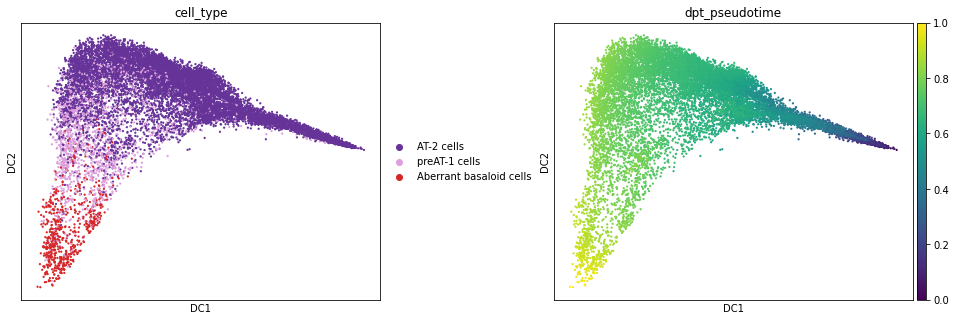

In [10]:
sc.pl.diffmap(alv, color = ["cell_type", "dpt_pseudotime"], wspace = 0.35, size = 20)

#### Figure 8 k) Scaled expression levels across the AT-2 cell pseudotime differentiation trajectory

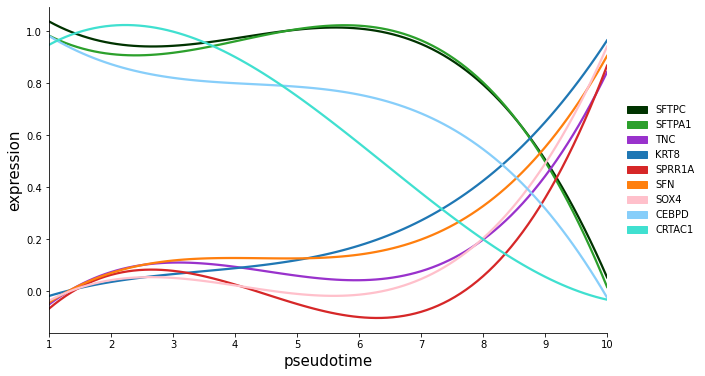

In [11]:
## Figure 8 Alveolar Epithel
genes = ["SFTPC", "SFTPA1", "TNC", "KRT8", "SPRR1A", "SFN", "SOX4", "CEBPD", "CRTAC1"]
cols = ["#003300", "tab:green", "darkorchid", "tab:blue", "tab:red", "tab:orange", "pink",
        "lightskyblue", "turquoise","brown"]

mean_dpt = get_scaled_meanExp(genes, alv, xlabel = "dpt_pseudotime")
lineplot_scaled_meanExp(mean_dpt, cols = cols, xlabel = "dpt_bins", figsize = (10, 6))

### AT-2 cell Trajectory after Bleomycin Treatment in Mice
Original dataset from Strunz et al. Nature Communications, 2019

In [12]:
## Create andata object based on meta file with selected genes of interest
alv_mice_meta = pd.read_csv(out_folder + "alvEpithel_bleoMice_metadata.txt", sep = "\t", index_col = 0)
alv_mice = sc.AnnData(X = alv_mice_meta.iloc[:, 4:11], obs = alv_mice_meta.iloc[:, 11:13])
alv_mice.obsm["X_diffmap"] = alv_mice_meta.loc[:, ["dc_0", "dc_1", "dc_2", "dc_3",]].values
sc._utils.sanitize_anndata(alv_mice)
alv_mice

... storing 'cell_type_recombined' as categorical


AnnData object with n_obs × n_vars = 16266 × 7
    obs: 'dpt_pseudotime', 'cell_type_recombined'
    obsm: 'X_diffmap'

#### Figure 8 l) Diffusion map of mouse AT2 cells colored by cell type identity and inferred pseudotime

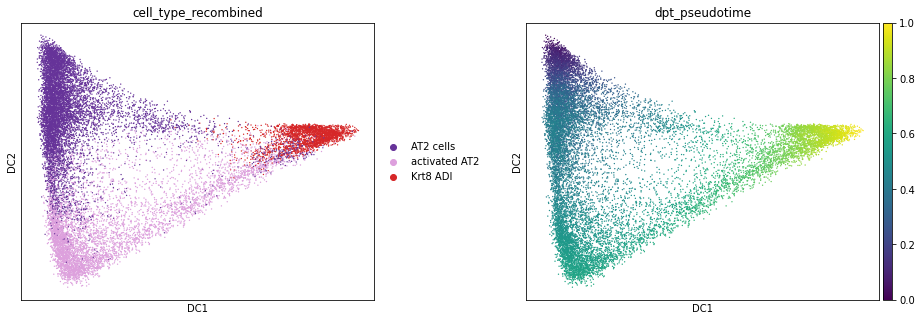

In [13]:
alv_mice.obs.cell_type_recombined.cat.reorder_categories(["AT2 cells", "activated AT2", "Krt8 ADI"], inplace = True)
alv_mice.uns["cell_type_recombined_colors"] = ["rebeccapurple", "plum", "tab:red"]
sc.pl.diffmap(alv_mice, color = ["cell_type_recombined", "dpt_pseudotime"], wspace = 0.3)

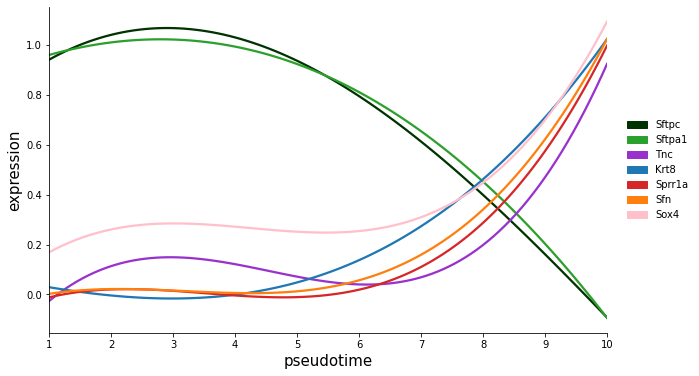

In [14]:
genes = ["Sftpc", "Sftpa1", "Tnc", "Krt8", "Sprr1a", "Sfn", "Sox4"]
cols = ["#003300", "tab:green", "darkorchid", "tab:blue", "tab:red", "tab:orange", "pink"]

mean_dpt = get_scaled_meanExp(genes, alv_mice, xlabel = "dpt_pseudotime")
lineplot_scaled_meanExp(mean_dpt, cols = cols, xlabel = "dpt_bins", figsize = (10, 6))